<a href="https://colab.research.google.com/github/lazouine/Project-2-Style-Transfer/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 Welcome to the Image Colorization Project

## Overview
Welcome 🧑‍🔬👩‍💻, to our thrilling exploration into the realm of image colorization! In this project, we'll be immersing ourselves in the captivating task of adding color to grayscale images 🖼️. Our objective is to develop a model that can accurately predict and apply colors to grayscale images, revitalizing them with vibrant hues 🌈.

## Project Objectives
- **Understanding Image Colorization**: Gain insights into the principles and techniques behind image colorization 🎨.
- **Exploring Deep Learning Models**: Dive into the world of deep learning architectures like U-Net for image colorization 🤖.
- **Model Training and Optimization**: Learn how to train and fine-tune neural networks to achieve optimal colorization results 🧠.
- **Real-World Applications**: Apply your skills to create a model capable of efficiently colorizing grayscale images, opening avenues for various practical applications 🌟.

## Dataset
We'll be utilizing the COCO (Common Objects in Context) dataset, which provides a diverse collection of grayscale images paired with their corresponding color images 📸. This dataset will serve as the foundation for training our U-Net-like network to accurately predict colors for grayscale inputs.

We compiled this dataset from the COCO dataset, ensuring diversity and quality.
If you're excited about this project, drop a message below! 🚀


## ⚠️ **Important: Use GPU Runtime** ⚠️

To ensure this notebook functions correctly and efficiently, it is **crucial to use a GPU runtime**. Follow these steps to enable GPU acceleration:

1. **Open Runtime settings**: At the top of the page, click on `Runtime` in the menu bar. 🔄

2. **Change the runtime type**: In the dropdown menu, select `Change runtime type`. 🛠️

3. **Select GPU as the hardware accelerator**: In the dialog that appears, under `Hardware accelerator`, choose `GPU T4` from the dropdown menu. 🖥️

4. **Save the settings**: Click `Save` to apply the changes. 💾

By enabling GPU, the computations in this notebook will be significantly faster, especially for tasks like training neural networks, processing large datasets, or performing complex calculations.


In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [ ]:
!pip install fastai==2.4 &> /dev/null
!pip install ipywidgets widgetsnbextension pandas-profiling &> /dev/null

In [ ]:
from fastai.data.external import untar_data, URLs

In [ ]:
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [ ]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


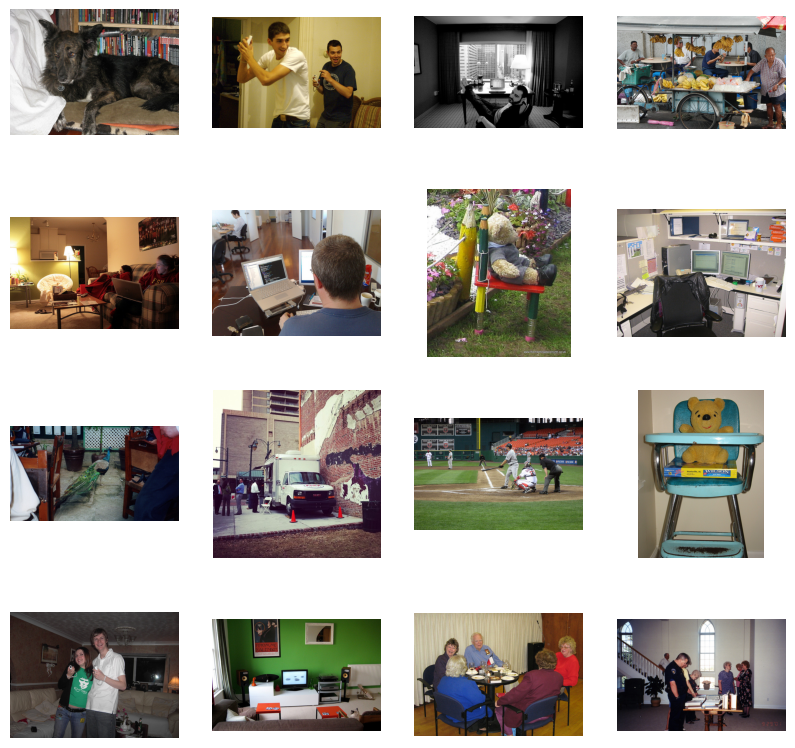

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [10]:
from data import *

In [13]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

RuntimeError: stack expects each tensor to be equal size, but got [1, 640, 3] at entry 0 and [1, 500, 3] at entry 1

In [14]:
from model import *

In [15]:
print(PatchDiscriminator(3))
# TODO: describe the Patch Discriminator role
#A Patch Discriminator evaluates local patches of images to distinguish between real and fake images, providing fine-grained feedback to the generator in GAN frameworks.

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [16]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

# Analyze the output
#This output suggests that for each input image in the batch, the Patch Discriminator produced a 30x30 grid of activation values, where each value represents the discriminator's confidence score for a local patch being real or fake.

torch.Size([16, 1, 30, 30])

In [20]:
# TODO: fix loss in GANLoss
from ganloss import *

In [21]:
# TODO: Test the weight initilizers
from weight_initializer import *

In [24]:
# TODO complete this model
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = nn.BCEWithLogitsLoss()
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        # TODO: define the backward of the descriminator
            pred_real = self.net_D(torch.cat([self.L, self.ab], dim=1))  # Forward pass with real images
            loss_D_real = self.GANcriterion(pred_real, self.real_label.expand_as(pred_real))  # Calculate loss
            loss_D_real.backward()  # Backpropagate the loss
            # Train discriminator with fake images
            fake_color = self.fake_color.detach()  # Detach fake_color from the computation graph
            pred_fake = self.net_D(torch.cat([self.L, fake_color], dim=1))  # Forward pass with fake images
            loss_D_fake = self.GANcriterion(pred_fake, self.fake_label.expand_as(pred_fake))  # Calculate loss
            loss_D_fake.backward()  # Backpropagate the loss


    def backward_G(self):
        # TODO: define the backward of the generator
        # Generator GAN loss
        pred_fake = self.net_D(torch.cat([self.L, self.fake_color], dim=1))  # Forward pass with fake images
        loss_G_GAN = self.GANcriterion(pred_fake, self.real_label.expand_as(pred_fake))  # Calculate GAN loss

    # L1 loss for image reconstruction
        loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1

    # Total Generator loss
        loss_G = loss_G_GAN + loss_G_L1  # Add GAN loss and L1 loss

    # Backpropagation
        self.opt_G.zero_grad()  # Clear previous gradients
        loss_G.backward()  # Backpropagate the total loss

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [25]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in train_dl:
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, 100)

model initialized with norm initialization
model initialized with norm initialization


RuntimeError: stack expects each tensor to be equal size, but got [1, 640, 3] at entry 0 and [1, 480, 3] at entry 2

In [ ]:
# TODO: Test it on your image !

image_path = 'images/image.jpg'  # Replace with your test image path
image = Image.open(image_path).convert('RGB')
from skimage import color
# Convert to numpy array and then to Lab color space
image_np = np.array(image)
image_lab = color.rgb2lab(image_np)

# Convert the model to Double
model.double()
# Extract L, a, b channels
L_channel = image_lab[:, :, 0]  # Luminance channel
a_channel = image_lab[:, :, 1]  # a color channel
b_channel = image_lab[:, :, 2]  # b color channel

# Preprocess (example - resize to match model input and convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize if needed (match your model input size)
    # Add any other transformations required by your model
])

L_tensor = transform(L_channel).unsqueeze(0).double() # Add batch dimension
ab_tensor = transform(np.stack([a_channel, b_channel], axis=2)).unsqueeze(0).double()  # Stack a and b, then convert

# If you only need L_tensor for inference, you can igno
# Assume 'model' is your loaded MainModel instance and 'input_data' is your prepared data
input_data = {'L': L_tensor, 'ab': ab_tensor}  # Replace with your actual data
model.setup_input(input_data)
model.forward()  # No arguments are passed here
colorized_image = model.fake_color  # This is your colorized output


# Process and visualize the output

In [ ]:
# Convert the tensor to a numpy array and change the order of dimensions
colorized_image_np = colorized_image.cpu().detach().numpy().squeeze()  # Remove batch dimension if present
colorized_image_np = np.transpose(colorized_image_np, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)

# Check the range of the output and adjust if necessary
# Example: If your model outputs in the range [-1, 1], rescale to the Lab range
colorized_image_np[:, :, 0] = (colorized_image_np[:, :, 0] + 1) * 50  # Scale L channel to [0, 100]
colorized_image_np[:, :, 1:] = colorized_image_np[:, :, 1:] * 110  # Scale a and b channels

# Combine L channel with colorized ab channels
complete_lab_image = np.zeros((256, 256, 3), dtype=np.float64)  # Assuming 256x256 output
complete_lab_image[:, :, 0] = L_tensor  # L channel from the original image
complete_lab_image[:, :, 1:] = colorized_image_np  # colorized ab channels

# Convert from Lab to RGB
complete_rgb_image = color.lab2rgb(complete_lab_image)

# Display the image
plt.imshow(complete_rgb_image)
plt.title("Colorized Image")
plt.axis('off')
plt.show()
